In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import os
import sys 
import json
import glob
import random
import collections
import time
import re
import math
import numpy as np
import pandas as pd
import cv2

In [2]:
from utils import load_dicom_image, load_dicom_images_3d

In [3]:
train_data_directory = 'D:/brain-classification-data/train'
data_directory = 'D:/brain-classification-data'

In [7]:
IMAGE_SIZE = 128
NUM_IMAGES = 64

(1, 256, 256, 64)
0.0 1.0 0.07902179328632788 0.00023671822699371212
Dimension of the CT scan is: (256, 256, 64)


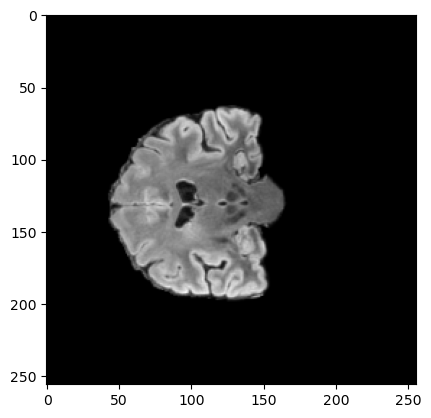

In [8]:
a = load_dicom_images_3d("00000", num_imgs=NUM_IMAGES, img_size=IMAGE_SIZE)
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))
image = a[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 15]), cmap="gray")